In [44]:
# Imports and Data Files
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
df = pd.read_csv('https://www1.columbia.edu/~chw2/Courses/APMA4903/2023/spotify-2023.csv', encoding='ISO-8859-1')

# Enter Liked / Disliked Songs Below

In [34]:
import ipywidgets as widgets
from IPython.display import display, clear_output

column = df['track_name'] + ' BY ' + df['artist(s)_name']
user_likes = []
user_dislikes = []

def create_dropdown(options, description):
    dropdown = widgets.Dropdown(
        options=column,
        value=column[0],  # Set default value if needed
        description=description
    )
    return dropdown

# Create and display 5 liked song dropdowns
print("Please enter 5 songs you like and 5 songs you dislike.")
liked_dropdowns = [create_dropdown(column, f"Like {i+1}:") for i in range(5)]
for dropdown in liked_dropdowns:
    display(dropdown)

# Create and display 5 disliked song dropdowns
disliked_dropdowns = [create_dropdown(column, f"Dislike {i+1}:") for i in range(5)]
for dropdown in disliked_dropdowns:
    display(dropdown)

# Create a button widget
run_button = widgets.Button(description='Run Notebook')

# Function to be called when the button is clicked
def on_button_click(b):
    clear_output()  # Clear the previous output
    
    # Get selected liked songs and add them to the list
    for dropdown in liked_dropdowns:
        track, artist = dropdown.value.split(' BY ')
        user_likes.append({'track_name': track, 
                       'artist(s)_name': artist}) 
    print(f'Liked Songs Selected: {user_likes}')
    
    # Get selected disliked songs and add them to the list
    for dropdown in disliked_dropdowns:
        track, artist = dropdown.value.split(' BY ')
        user_dislikes.append({'track_name': track, 
                       'artist(s)_name': artist}) 
    print(f'Disliked Songs Selected: {user_dislikes}')

# Attach the function to the button click event
run_button.on_click(on_button_click)

# Display the button
display(run_button)

Please enter 5 songs you like and 5 songs you dislike.


Dropdown(description='Like 1:', options=('Seven (feat. Latto) (Explicit Ver.) BY Latto, Jung Kook', 'LALA BY M…

Dropdown(description='Like 2:', options=('Seven (feat. Latto) (Explicit Ver.) BY Latto, Jung Kook', 'LALA BY M…

Dropdown(description='Like 3:', options=('Seven (feat. Latto) (Explicit Ver.) BY Latto, Jung Kook', 'LALA BY M…

Dropdown(description='Like 4:', options=('Seven (feat. Latto) (Explicit Ver.) BY Latto, Jung Kook', 'LALA BY M…

Dropdown(description='Like 5:', options=('Seven (feat. Latto) (Explicit Ver.) BY Latto, Jung Kook', 'LALA BY M…

Dropdown(description='Dislike 1:', options=('Seven (feat. Latto) (Explicit Ver.) BY Latto, Jung Kook', 'LALA B…

Dropdown(description='Dislike 2:', options=('Seven (feat. Latto) (Explicit Ver.) BY Latto, Jung Kook', 'LALA B…

Dropdown(description='Dislike 3:', options=('Seven (feat. Latto) (Explicit Ver.) BY Latto, Jung Kook', 'LALA B…

Dropdown(description='Dislike 4:', options=('Seven (feat. Latto) (Explicit Ver.) BY Latto, Jung Kook', 'LALA B…

Dropdown(description='Dislike 5:', options=('Seven (feat. Latto) (Explicit Ver.) BY Latto, Jung Kook', 'LALA B…

Button(description='Run Notebook', style=ButtonStyle())

In [35]:
user_likes, user_dislikes = pd.DataFrame(user_likes), pd.DataFrame(user_dislikes)
user_likes

,track_name,artist(s)_name
0,Kill Bill,SZA
1,vampire,Olivia Rodrigo
2,Cruel Summer,Taylor Swift
3,Columbia,Quevedo
4,Heat Waves,Glass Animals


In [36]:
features = df.columns.values.tolist()
print(features)

['track_name', 'artist(s)_name', 'artist_count', 'released_year', 'released_month', 'released_day', 'in_spotify_playlists', 'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts', 'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 'bpm', 'key', 'mode', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']


# Audio Based Recommendations

## Preprocessing
Create function that labels song likeability label by specific individual's liked and disliked songs

In [37]:
#get relevant numerical features
numerical_labels = df._get_numeric_data().columns.values.tolist()
num_features = numerical_labels[9:]
print(num_features)
ohe_features = []
feature_names = numerical_labels + ohe_features
ALL_FEATURES = False

['bpm', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']


### Explore Correlations between Numerical Features
High correlation between # spotify playlists and # of apple playlists, but otherwise different features are not heavily correlated.

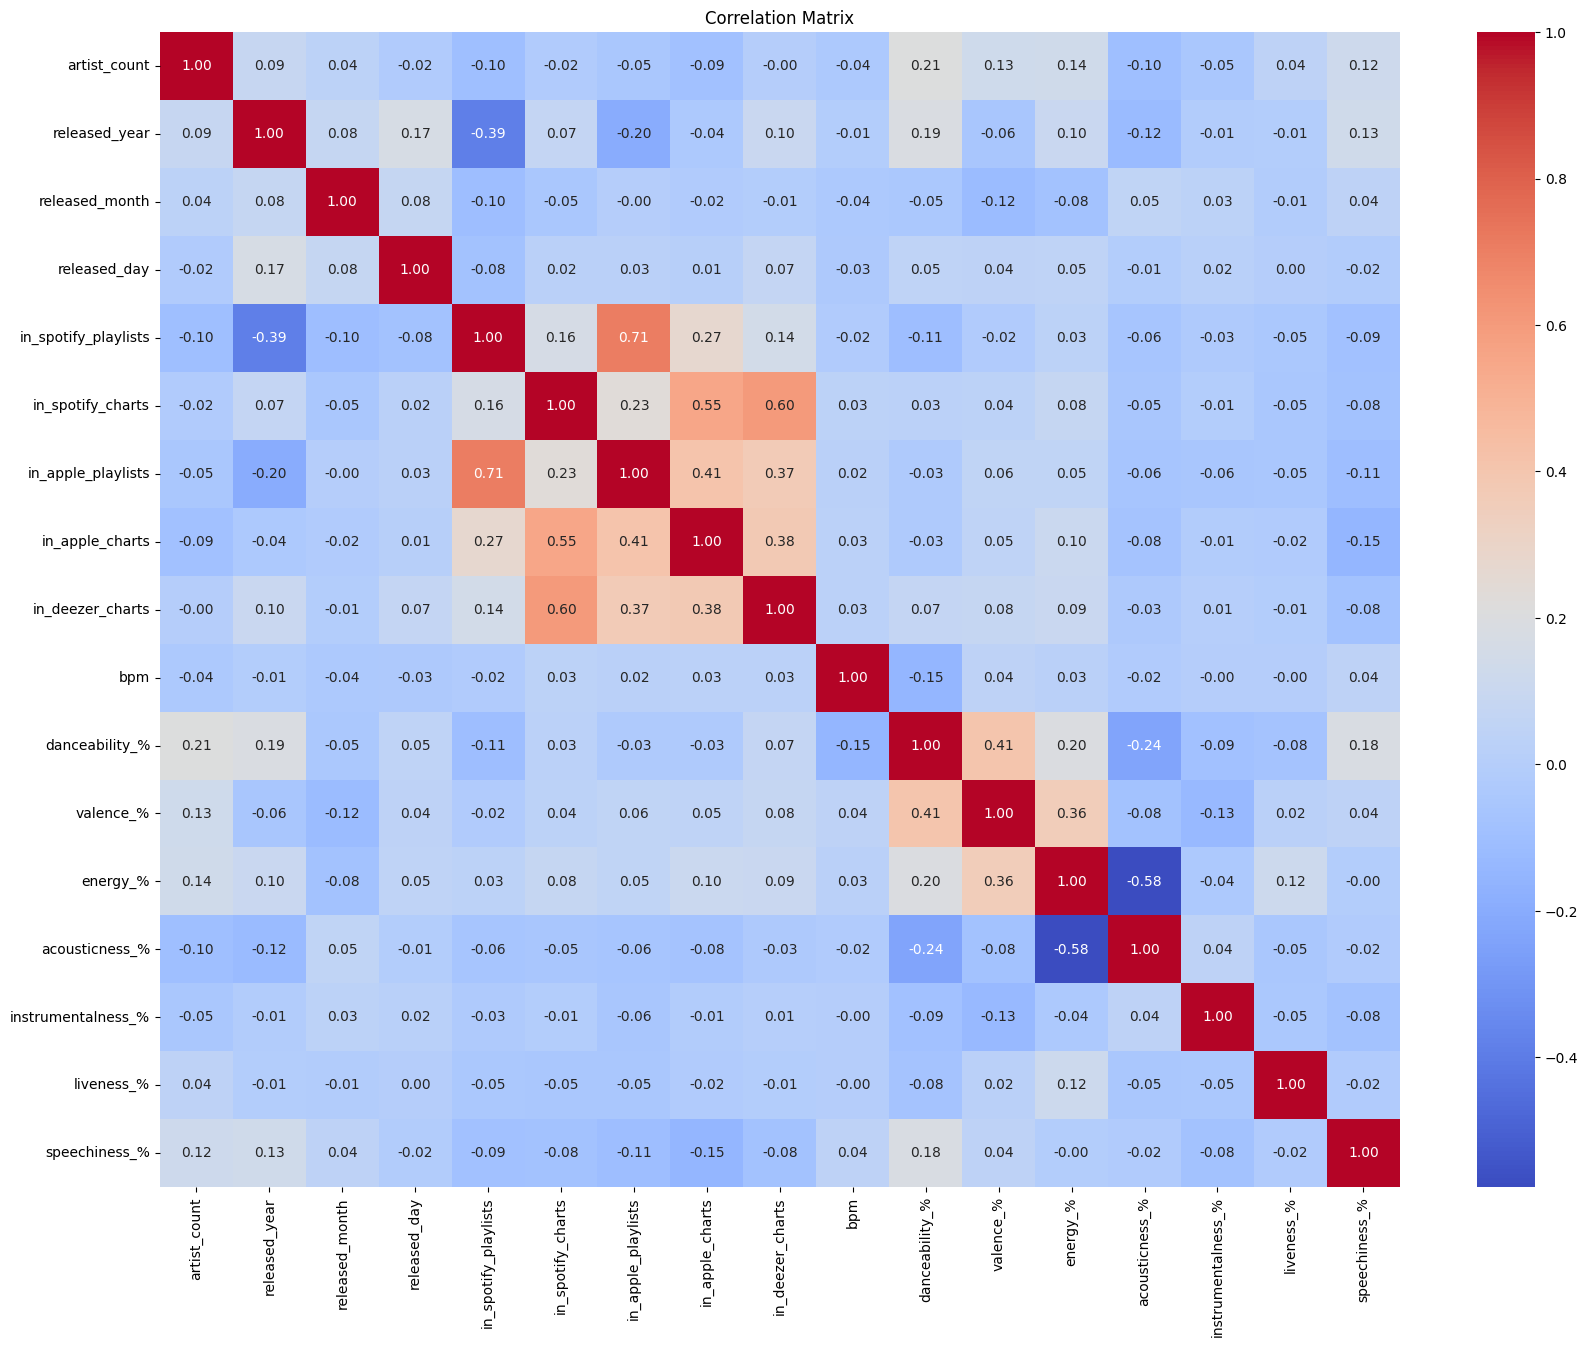

In [43]:
correlation_matrix = df[numerical_labels].corr()
plt.figure(figsize=(20, 15))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### Generate Labels using User Likes/Dislikes

In [43]:
def generate_labels(df, liked, disliked):
    liked_titles, liked_artists = list(liked["track_name"].values), list(liked["artist(s)_name"].values)
    disliked_titles, disliked_artists = list(disliked["track_name"].values), list(disliked["artist(s)_name"].values)
    all_titles = liked_titles + disliked_titles    
    training = df[df['track_name'].isin(all_titles)]
    testing = df[~df['track_name'].isin(all_titles)]
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        training.loc[:, 'liked_label'] = np.where(training['track_name'].isin(liked_titles), 1, -1)

    return training, testing

In [39]:
def generate_plot_weights(model, isBoosting=False):
    if isBoosting:
        weights = model.feature_importances_
    else:
        weights = model.coef_[0]
    
    cols = feature_names if ALL_FEATURES else num_features
    plt.bar(cols, weights)
    plt.xlabel('Category')
    plt.ylabel('Weight Assigned')
    plt.title('Weight Assigned per Feature')
    plt.xticks(rotation=90)
    plt.show()

## Logistic Regression

In [42]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
import numpy as np

def SongLogisticRegression(likes, dislikes):
    train, test = generate_labels(df, likes, dislikes)
    dev_y = train.loc[:, ['liked_label']]
    dev_X = train.loc[:, train.columns != 'liked_label']
    test_X = test.loc[:, test.columns != 'liked_label']

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        if ALL_FEATURES:
          preprocess = make_column_transformer((StandardScaler(), feature_names))

        else:
          preprocess = make_column_transformer((StandardScaler(), num_features))

        logisticRegr = LogisticRegression()
        pipe = make_pipeline(preprocess, logisticRegr)

        pipe.fit(dev_X, dev_y)
        test_X.loc[:, 'pred'] = pipe.predict_proba(test_X)[:,1] * pipe.predict(test_X)
    
    return test_X, logisticRegr

#### Predictions for User

In [45]:
predictions, model = SongLogisticRegression(user_likes, user_dislikes)
predictions[['track_name', 'artist(s)_name', 'pred']].sort_values('pred', ascending=False).head(5)

,track_name,artist(s)_name,pred
209,Area Codes,"Kaliii, Kaliii",0.998258
247,Cartï¿½ï¿½o B,"MC Caverinha, KayBlack",0.998225
933,Vigilante Shit,Taylor Swift,0.997865
880,Baile no Morro,"Mc Vitin Da Igrejinha, MC Tairon, DJ Win",0.996700
935,On BS,"Drake, 21 Savage",0.996194


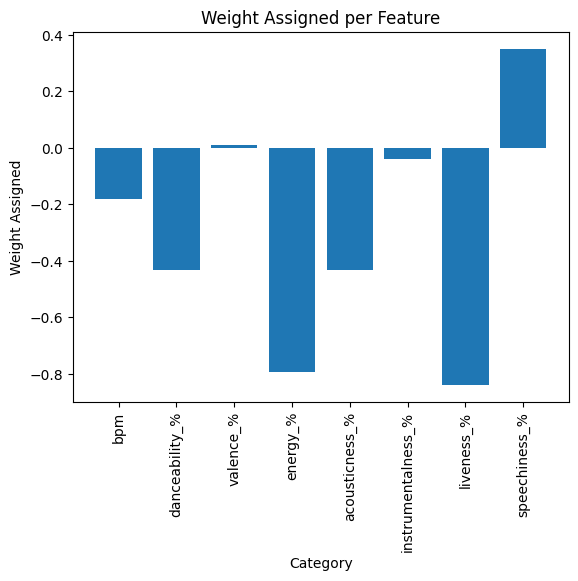

In [46]:
generate_plot_weights(model)

## Support Vector Machines (SVMs)

In [47]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import LinearSVC
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def SongsSVM(likes, dislikes):
    train, test = generate_labels(df, likes, dislikes)
    dev_y = train.loc[:, ['liked_label']]
    dev_X = train.loc[:, train.columns != 'liked_label']
    test_X = test.loc[:, test.columns != 'liked_label']

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        if ALL_FEATURES:
            preprocess = make_column_transformer((StandardScaler(), feature_names))

        else:
            preprocess = make_column_transformer((StandardScaler(), num_features))

        svmRegr = LinearSVC(C=0.1, penalty='l2', loss='squared_hinge', dual=True)
        pipe = make_pipeline(preprocess, svmRegr)

        pipe.fit(dev_X, dev_y)
        probs = sigmoid(pipe.decision_function(test_X))
        test_X.loc[:, 'pred'] = probs * pipe.predict(test_X)
        
    return test_X, svmRegr

In [48]:
svm_predictions, svm_model = SongsSVM(user_likes, user_dislikes)
svm_predictions[['track_name', 'artist(s)_name', 'pred']].sort_values('pred', ascending=False).head(5)

,track_name,artist(s)_name,pred
209,Area Codes,"Kaliii, Kaliii",0.933644
247,Cartï¿½ï¿½o B,"MC Caverinha, KayBlack",0.932539
933,Vigilante Shit,Taylor Swift,0.927983
880,Baile no Morro,"Mc Vitin Da Igrejinha, MC Tairon, DJ Win",0.915629
935,On BS,"Drake, 21 Savage",0.910381


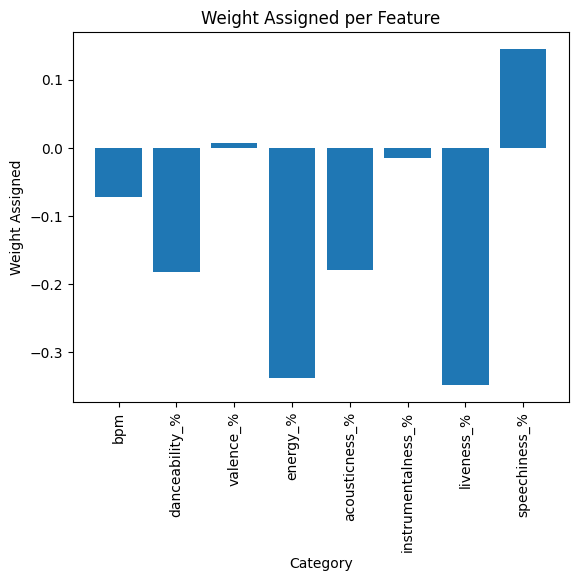

In [49]:
generate_plot_weights(svm_model)

## Boosting

In [50]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np

def SongsBoosting(likes, dislikes):
    train, test = generate_labels(df, likes, dislikes)
    dev_y = train.loc[:, ['liked_label']]
    dev_X = train.loc[:, train.columns != 'liked_label']
    test_X = test.loc[:, test.columns != 'liked_label']
    param_grid = {'n_estimators': [50,100,200],
                'learning_rate':np.logspace(-3,0,4)}

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        if ALL_FEATURES:
            preprocess = make_column_transformer((StandardScaler(), feature_names))

        else:
            preprocess = make_column_transformer((StandardScaler(), num_features))

        boostRegr = AdaBoostRegressor(DecisionTreeRegressor(), random_state=42)
        pipe = make_pipeline(preprocess, GridSearchCV(boostRegr, param_grid = param_grid))
        pipe.fit(dev_X, dev_y)
        test_X['pred'] = pipe.predict(test_X)
        best_model = pipe.named_steps['gridsearchcv'].best_estimator_

    return test_X, best_model

In [51]:
boost_predictions, boost_model = SongsBoosting(user_likes, user_dislikes)
boost_predictions[['track_name', 'artist(s)_name', 'pred']].sort_values('pred', ascending=False).head(5)

,track_name,artist(s)_name,pred
952,Alone,Burna Boy,1.0
836,Little Freak,Harry Styles,1.0
510,Infinity,Jaymes Young,1.0
511,Less Than Zero,The Weeknd,1.0
512,Take My Breath,The Weeknd,1.0


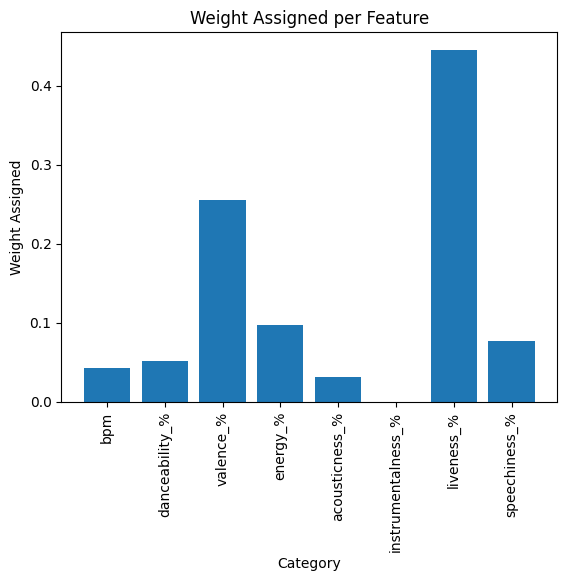

In [52]:
generate_plot_weights(boost_model, True)

## Overall Weights

#### Generate Plots

In [53]:
def generate_overall_weight_plots(log_model, svm_model, boost_model):
    width=0.25
    log_weight = log_model.coef_[0]
    svm_weight = svm_model.coef_[0]
    boost_weight = boost_model.feature_importances_
    weights = [log_weight, svm_weight, boost_weight]
    labels = ['logistic', 'svm', 'boosting']
    cols = feature_names if ALL_FEATURES else num_features
    x_axis = np.arange(len(cols))
    
    for i in range(len(labels)):
        plt.bar(x_axis + (width*i), weights[i], width=width, label=labels[i])
    
    plt.xlabel('Category')
    plt.ylabel('Weight Assigned')
    plt.title('Weight Assigned per Feature')
    plt.xticks(x_axis, cols, rotation=90)
    plt.legend()
    plt.show()

#### Model Weights

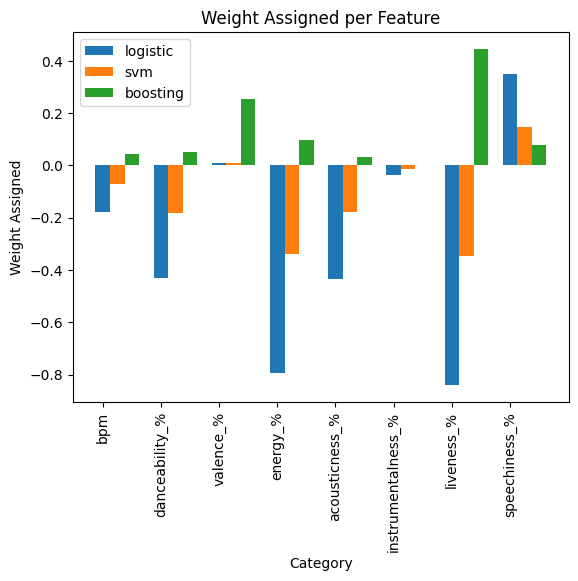

In [54]:
generate_overall_weight_plots(model, svm_model, boost_model)

# Lyrics Based Recommendations

In [55]:
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from tqdm import tqdm

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import nltk
from nltk.corpus import stopwords

In [57]:
df = pd.read_csv('https://raw.githubusercontent.com/apma4903/APMA4903-2023-11-27/main/spotify_with_lyrics.csv', encoding='UTF-8')
df.loc[df['Lyrics'].notnull(), ['track_name', 'artist(s)_name', 'Lyrics']].head()

,track_name,artist(s)_name,Lyrics
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",Weight of the world on your shoulders\nI kiss ...
1,LALA,Myke Towers,"Todo está bien, no te tiene' que estresar\nA t..."
2,vampire,Olivia Rodrigo,Hate to give the satisfaction asking how you'r...
3,Cruel Summer,Taylor Swift,"(Yeah, yeah, yeah, yeah)\n\nFever dream high i..."
4,WHERE SHE GOES,Bad Bunny,"Baby, dime la verdad\nSi te olvidaste de mí\nY..."


In [58]:
lyrics_corpus = df['Lyrics'].fillna('')

## TF - IDF

In [59]:
# Download the stopwords for English and Spanish
nltk.download('stopwords')
nltk.download('stopwords_es')

stopword_en = stopwords.words('english')
stopword_es = stopwords.words('spanish')
stopwords_all = stopword_en + stopword_es

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anany\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading stopwords_es: Package 'stopwords_es' not
[nltk_data]     found in index


In [60]:
vectorizer = TfidfVectorizer(stop_words = stopwords_all)
tfidf_song_vectors = np.array(vectorizer.fit_transform(lyrics_corpus).todense())

## Word2Vec

In [61]:
def get_sequence_vector(words, model, vector_size=100):
    vectors = [model.wv[word] for word in words if word in model.wv]
    
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

In [62]:
w2v_corpus = lyrics_corpus.apply(lambda x : x.split())
word2vec_model = Word2Vec(sentences=w2v_corpus,
                          vector_size=100, window=5,
                          min_count=1, workers=4)
w2v_song_vectors = w2v_corpus.apply(lambda x : get_sequence_vector(x, word2vec_model, vector_size=100))
w2v_song_vectors = np.array(w2v_song_vectors.values.tolist())

## BERT

In [181]:
bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Tokenize and encode the lyrics
bert_lyrics_corpus = lyrics_corpus.tolist()
lyrics_tokens = bert_tokenizer(bert_lyrics_corpus, padding=True, truncation=True, return_tensors='pt')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Takes 16 minutes to run with DistilBert

In [182]:
# Get the number of batches (assuming batch_size=1 for simplicity)
num_batches = len(lyrics_tokens['input_ids'])

# Create a tqdm progress bar
progress_bar = tqdm(total=num_batches, desc="Processing BERT")

# Process each batch
with torch.no_grad():
    bert_song_vectors = []
    for batch_start in range(0, num_batches):
        batch = {key: value[batch_start] for key, value in lyrics_tokens.items()}
        outputs = bert_model(**batch)
        bert_song_vectors.append(outputs['last_hidden_state'].mean(dim=1).numpy()[0])

        # Update the progress bar
        progress_bar.update(1)

# Close the progress bar
progress_bar.close()

Processing BERT: 100%|██████████| 953/953 [25:02<00:00,  1.58s/it]


## Lyrics Based Recommendation Generator

In [65]:
def LyricsBasedSongRecommendations(likes, dislikes, df, model_type = 'word2vec'):
    
    liked_titles, liked_artists = list(likes["track_name"].values), list(likes["artist(s)_name"].values)
    disliked_titles, disliked_artists = list(dislikes["track_name"].values), list(dislikes["artist(s)_name"].values)
    
    liked_indices = df[(df['track_name'].isin(liked_titles)) & (df['artist(s)_name'].isin(liked_artists))]
    disliked_indices = df[(df['track_name'].isin(disliked_titles)) & (df['artist(s)_name'].isin(disliked_artists))]

    lyrics_corpus = df['Lyrics'].fillna('')

    if model_type == 'word2vec':
        song_vectors = w2v_song_vectors

    elif model_type == 'bert':
        song_vectors = bert_song_vectors

    elif model_type == 'tfidf':
        song_vectors = tfidf_song_vectors

    else:
        raise ValueError("Unsupported model_type. Supported types are 'tfidf', 'word2vec' and 'bert'.")

    cosine_similarities = cosine_similarity(song_vectors, song_vectors)

    liked_scores = cosine_similarities[:, liked_indices.index].sum(axis = 1)
    disliked_scores = cosine_similarities[:, disliked_indices.index].sum(axis = 1)
    combined = liked_scores - disliked_scores

    df['score'] = combined

    return df

In [68]:
userdf = LyricsBasedSongRecommendations(user_likes, user_dislikes, df)
userdf[['track_name', 'artist(s)_name', 'Lyrics', 'score']].sort_values(by='score', ascending=False)[['track_name', 'artist(s)_name', 'score']]
userdf.loc[(~userdf['track_name'].isin(user_likes)) & (userdf['Lyrics'].notnull()), ['track_name', 'artist(s)_name', 'Lyrics', 'score']].sort_values(by='score', ascending=False)

2          vampire
3     Cruel Summer
7         Columbia
15       Kill Bill
71      Heat Waves
Name: track_name, dtype: object
66           Karma
72     golden hour
264           I AM
274        Shivers
Name: track_name, dtype: object


,track_name,artist(s)_name,Lyrics,score
594,Sobrio,Maluma,Quiero aprovechar ya que estoy tomao\nPa' pode...,0.894217
239,Efecto,Bad Bunny,Yeah-yeah-yeah-yeah-yeah-yeah\nEh-eh-eh-eh\n\n...,0.893433
397,Te Felicito,"Shakira, Rauw Alejandro",Por completarte me rompí en pedazos\nMe lo adv...,0.893274
18,Classy 101,"Feid, Young Miko",To' los día' te imagino\nComo te debes ver sin...,0.893104
332,Tormenta (feat. Bad Bunny),"Gorillaz, Bad Bunny",The sun has gone\nSomeone crying\nSomething is...,0.893031
...,...,...,...,...
844,So Good,Halsey,"Looking right, looking like\nAll the stars are...",0.458843
560,Life Goes On,Oliver Tree,"Babe, you're too controlling\nI'ma feed you to...",0.458827
322,I Love You So,The Walters,I just need someone in my life to give it stru...,0.458714
762,Love Yourself,Justin Bieber,For all the times that you rained on my parade...,0.457610
